# Solving a sudoku

- http://norvig.com/sudoku.html
- https://github.com/udacity/aind-sudoku

## What is a Sudoku?

Sudoku is one of the world's most popular puzzles. It consists of a 9x9 grid, and the objective is to fill the grid with digits in such a way that each row, each column, and each of the 9 principal 3x3 subsquares contains all of the digits from 1 to 9. The puzzle is given as a partially completed grid, and the goal is to fill in the missing numbers. 

Your solution probably consisted of the following two steps (and maybe more):
- If a box has a value, then all the boxes in the same row, same column, or same 3x3 square cannot have that same value.
- If there is only one allowed value for a given box in a row, column, or 3x3 square, then the box is assigned that value.


## Goal of this project

The main goal of this project is to build an intelligent agent that will solve every sudoku while introducing you to two powerful techniques that are used throughout the field of AI:

### Constraint Propagation
When trying to solve a problem, you'll find that there are some **local constraints** to each square. These constraints help you narrow the possibilities for the answer, which can be very helpful. We will learn **to extract the maximum information out of these constraints in order to get closer to our solution.** Additionally, you'll see how we can **repeatedly apply simple constraints to iteratively narrow the search space** of possible solutions. Constraint propagation can be used to solve a variety of problems such as calendar scheduling, and cryptographic puzzles.

### Search
In the process of problem solving, we may get to the point **where two or more possibilities are available.** What do we do? What if we branch out and consider both of them? Maybe one of them will lead us to a position in which three or more possibilities are available. Then, we can branch out again. At the end, we can **create a whole tree of possibilities and find ways to traverse the tree** until we find our solution.


These ideas may seem simple and they're actually intended to be! Through this lesson you'll see how AI is really composed of very simple ideas that can be put together to solve complex problems. Throughout this lesson, we challenge you to think of how you can apply these ideas to build AI agents to solve other puzzles and problems in your world!


# Setting up a board

## Naming Conventions
### Rows and columns

The rows will be labelled by the letters A, B, C, D, E, F, G, H, I.
The columns will be labelled by the numbers 1, 2, 3, 4, 5, 6, 7, 8, 9. Here we can see the unsolved and solved puzzles with the labels for the rows and columns.
The 3x3 squares won't be labelled, but in the diagram, they can be seen with alternating colors of grey and white.


### Boxes, Units, and Peers
The individual squares at the intersection of rows and columns will be called boxes. These boxes will have labels 'A1', 'A2', ..., 'I9'.
The complete rows, columns, and 3x3 squares, will be called units. Thus, each unit is a set of 9 boxes, and there are 27 units in total.
For a particular box (such as 'A1'), its peers will be all other boxes that belong to a common unit (namely, those that belong to the same row, column, or 3x3 square).


### Diagonal sudoku

A diagonal sudoku is like a regular sudoku, except that among the two main diagonals, the numbers 1 to 9 should all appear exactly once. In this project, you'll modify the functions we've written in the lecture (or you can write your own!) in order to solve every diagonal sudoku.

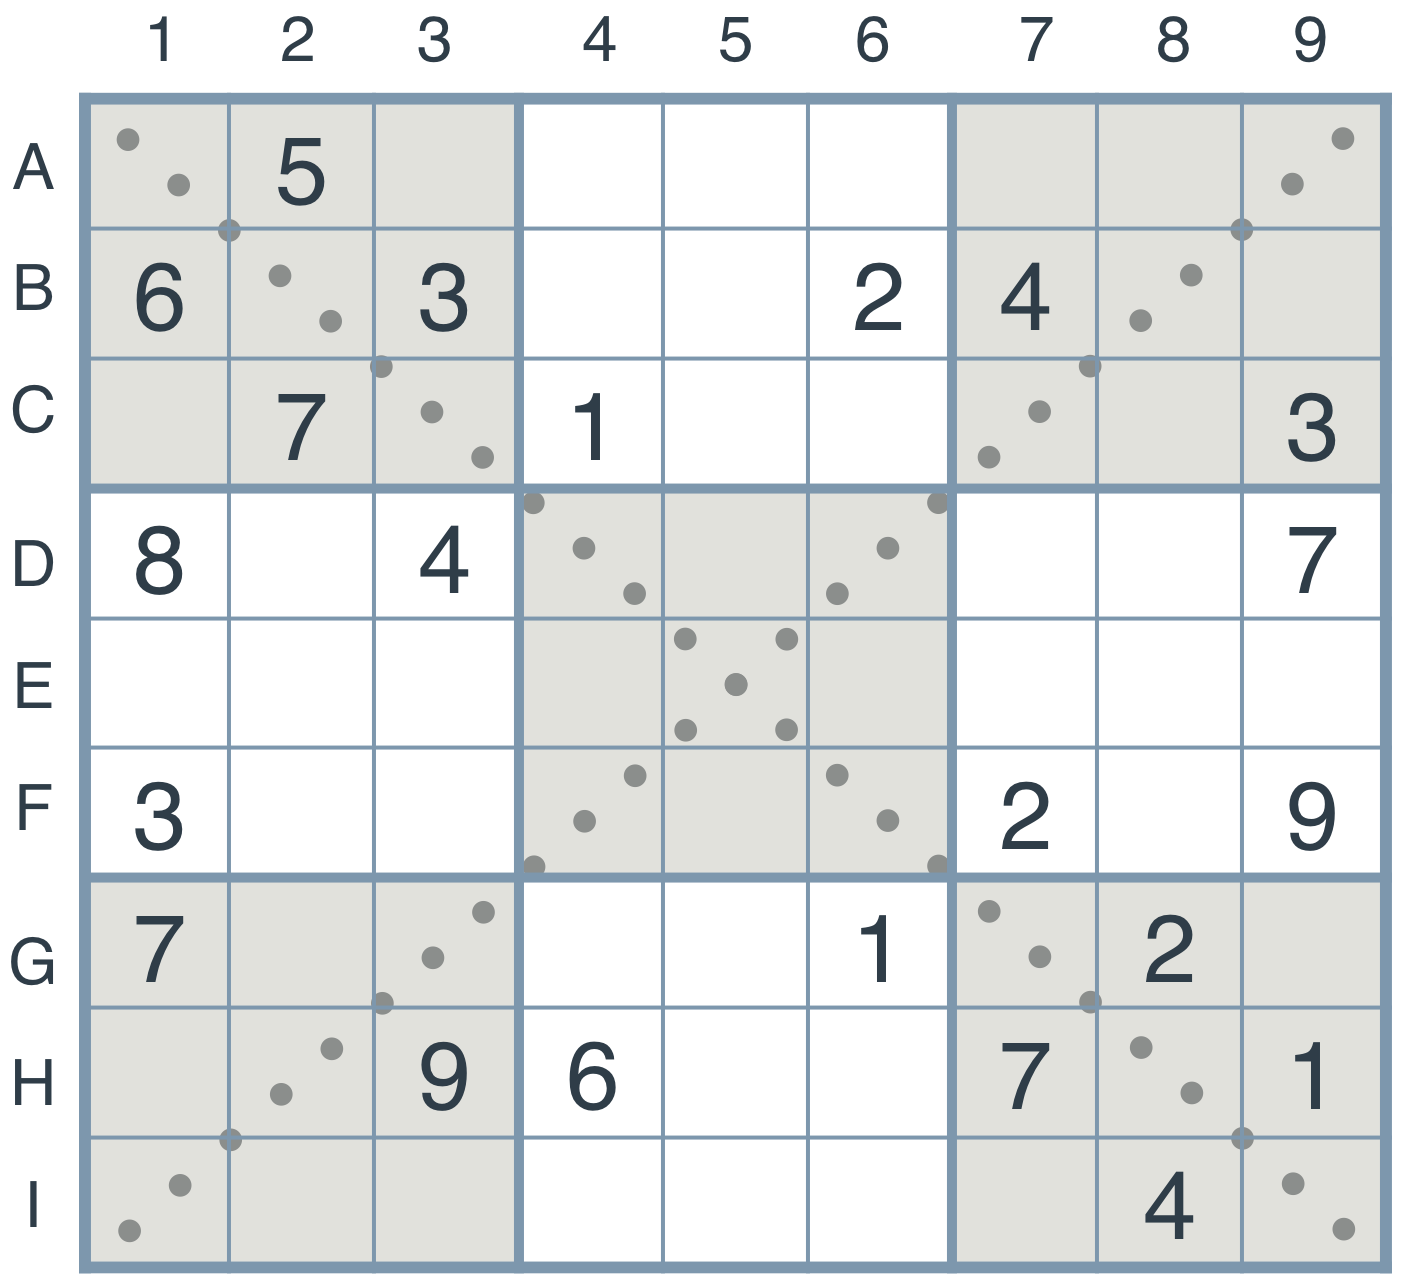

In [63]:
Image('images/diagonal-sudoku.png', height=300, width=300)

## Encoding the board

In [1]:
rows = 'ABCDEFGHI'
cols = '123456789'

def cross(a, b):
      return [s+t for s in a for t in b]

In [2]:
boxes = cross(rows, cols)

In [3]:
row_units = [cross(r, cols) for r in rows]
column_units = [cross(rows, c) for c in cols]
square_units = [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')]
diag_units = [[r + c for r, c in zip(rows, cols)], [r + c for r, c in zip(rows, cols[::-1])]]
unitlist = row_units + column_units + square_units + diag_units

units = dict((s, [u for u in unitlist if s in u]) for s in boxes)
peers = dict((s, set(sum(units[s],[])) - set([s])) for s in boxes)

In [4]:
assignments = []

def assign_value(values, box, value):
    """
    Please use this function to update your values dictionary!
    Assigns a value to a given box. If it updates the board record it.
    """

    # Don't waste memory appending actions that don't actually change any values
    if values[box] == value:
        return values

    values[box] = value
    if len(value) == 1:
        assignments.append(values.copy())
    return values

In [6]:
def grid_values(grid):
    """Convert grid string into {<box>: <value>} dict with '123456789' value for empties.

    Args:
        grid: Sudoku grid in string form, 81 characters long
    Returns:
        Sudoku grid in dictionary form:
        - keys: Box labels, e.g. 'A1'
        - values: Value in corresponding box, e.g. '8', or '123456789' if it is empty.
    """
    values = []
    all_digits = '123456789'
    for c in grid:
        if c == '.':
            values.append(all_digits)
        elif c in all_digits:
            values.append(c)
    assert len(values) == 81
    return dict(zip(boxes, values))


In [7]:
def display(values):
    """
    Display the values as a 2-D grid.
    Input: The sudoku in dictionary form
    Output: None
    """
    if not values:
        print("there is a box with zero available values!")
    
    width = 1+max(len(values[s]) for s in boxes)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print(''.join(values[r+c].center(width)+('|' if c in '36' else '') for c in cols))
        if r in 'CF': 
            print(line)
    return

In [27]:
diag_grid = '4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
display(grid_values(diag_grid))

    4     123456789 123456789 |123456789 123456789 123456789 |    8     123456789     5     
123456789     3     123456789 |123456789 123456789 123456789 |123456789 123456789 123456789 
123456789 123456789 123456789 |    7     123456789 123456789 |123456789 123456789 123456789 
------------------------------+------------------------------+------------------------------
123456789     2     123456789 |123456789 123456789 123456789 |123456789     6     123456789 
123456789 123456789 123456789 |123456789     8     123456789 |    4     123456789 123456789 
123456789 123456789 123456789 |123456789     1     123456789 |123456789 123456789 123456789 
------------------------------+------------------------------+------------------------------
123456789 123456789 123456789 |    6     123456789     3     |123456789     7     123456789 
    5     123456789 123456789 |    2     123456789 123456789 |123456789 123456789 123456789 
    1     123456789     4     |123456789 123456789 123456789 |12345678

# Strategy 1: Elimination

In [25]:
def eliminate(values):
    """Eliminate values from peers of each box with a single value.

    Go through all the boxes, and whenever there is a box with a single value,
    eliminate this value from the set of values of all its peers.

    Args:
        values: Sudoku in dictionary form.
    Returns:
        Resulting Sudoku in dictionary form after eliminating values.
    """
    solved_values = [box for box in values.keys() if len(values[box]) == 1]
    for box in solved_values:
        digit = values[box]
        for peer in peers[box]:
            if len(values[peer]) > 1:
                #values[peer] = values[peer].replace(digit,'')
                values = assign_value(values, peer, values[peer].replace(digit,''))
    return values

In [28]:
eliminated = eliminate(grid_values(diag_grid))
display(eliminated)

   4      1679   12679  |  139     2369    1269  |   8      1239     5    
 26789     3    1256789 | 14589   24569  1245689 | 12679    249    124679 
  2689   15689   12569  |   7     234569 1245689 |  2369   12349   123469 
------------------------+------------------------+------------------------
  3789     2     135789 |   59    34579    479   | 13579     6     13789  
  3679   15679   135679 |  359      8     25679  |   4     12359   12379  
 36789   456789  356789 |  349      1     25679  | 23579   23589   23789  
------------------------+------------------------+------------------------
  289      89      29   |   6      459      3    |  1259     7     12489  
   5      679    36789  |   2      479    14789  |  1369     19    134689 
   1      6789     4    |  589     579     5789  | 23569   23589    269   


# Strategy 2: Only choice

In [29]:
def only_choice(values):
    """Finalize all values that are the only choice for a unit.

    Go through all the units, and whenever there is a unit with a value
    that only fits in one box, assign the value to this box.

    Input: Sudoku in dictionary form.
    Output: Resulting Sudoku in dictionary form after filling in only choices.
    """
    for unit in unitlist:
        for digit in '123456789':
            dplaces = [box for box in unit if digit in values[box]]
            if len(dplaces) == 1:
                #values[dplaces[0]] = digit
                values = assign_value(values, dplaces[0], digit)
    return values

In [255]:
values = only_choice(eliminated)
display(values)

   4      1679   12679  |  139     2369    1269  |   8      1239     5    
 26789     3    1256789 | 14589   24569  1245689 | 12679    249    124679 
  2689   15689   12569  |   7     234569 1245689 |  2369   12349   123469 
------------------------+------------------------+------------------------
  3789     2     135789 |   59    34579    479   | 13579     6     13789  
  3679   15679   135679 |  359      8       2    |   4     12359   12379  
 36789     4     356789 |  349      1       7    | 23579   23589   23789  
------------------------+------------------------+------------------------
  289      89      29   |   6      459      3    |  1259     7       4    
   5      679      3    |   2      479      1    |  1369     19      8    
   1      6789     4    |  589     579     5789  | 23569   23589    269   


Some things to watch out for:

- The function needs to stop if the puzzle gets solved. How to do this?
- What if the function doesn't solve the sudoku? Can we make sure the function quits when applying the two strategies stops making progress?


# Stragey 3: Naked twins
As we can see, both belong to the same column, and both permit the values of 2 and 3. Now, we don't know which one has a 2 and which one has a 3, but we know one thing for sure — the values 2 and 3 are locked in those two boxes, so no other box in their same unit (the third column) can contain the values 2 or 3.

Thus, we go over all the boxes in their same unit, and remove the values 2 and 3 from their possible values.


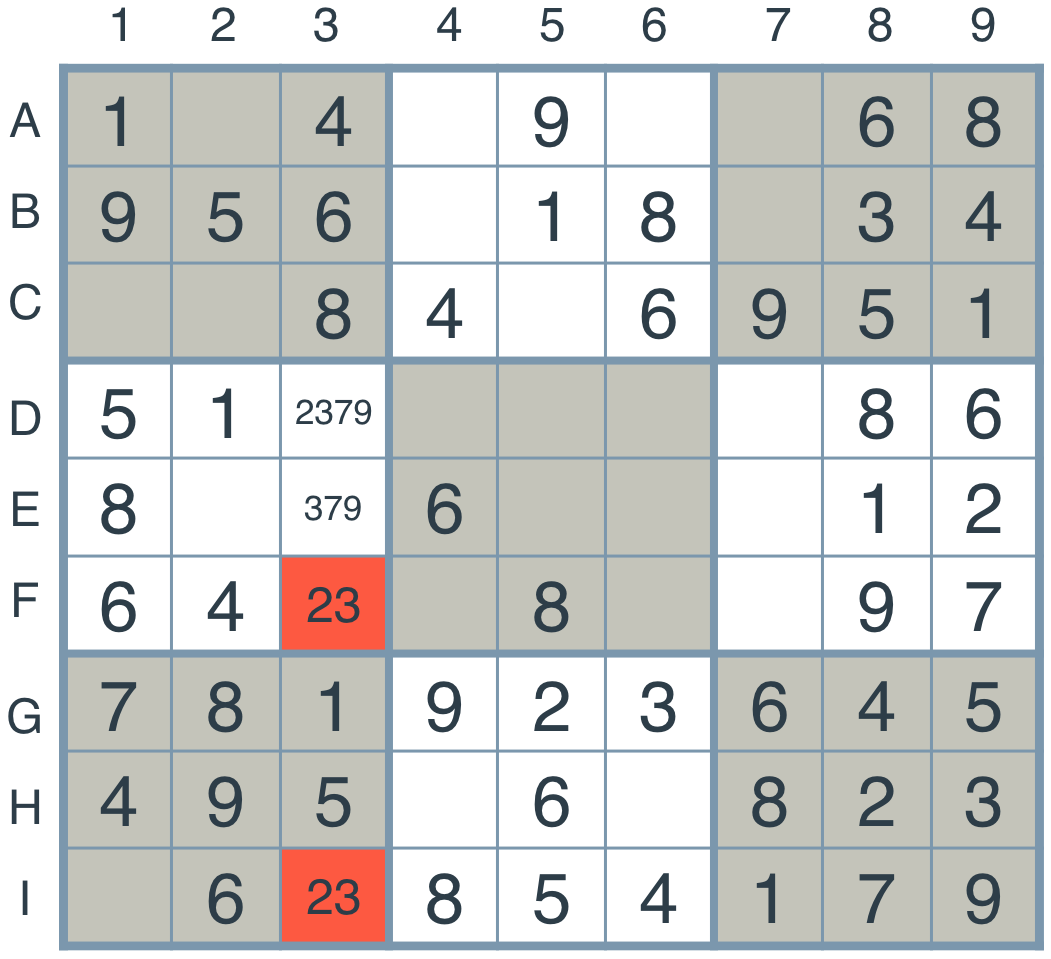

In [44]:
from IPython.display import Image
Image('images/naked-twins.png', height=300, width=300)

In [118]:
import numpy as np
def naked_twins(values):
    """Eliminate values using the naked twins strategy.
    Args:
        values(dict): a dictionary of the form {'box_name': '123456789', ...}
    Returns:
        the values dictionary with the naked twins eliminated from peers.
    """

    # Find all instances of naked twins
    two_digits = [box for box in values.keys() if len(values[box]) == 2]
    for unit in unitlist:
        if len(np.intersect1d(unit, two_digits)) > 1:
            possible_twins = combinations(np.intersect1d(unit, two_digits), 2)
            for a, b in possible_twins:
                if values[a] == values[b]:
                
                # Eliminate the naked twins as possibilities for their peers
                    others = np.setdiff1d(unit, [a, b])
                    twin_digits = values[a]
                    for box in others:
                        for d in twin_digits:
                            if len(values[box]) > 1:
                                #values[box] = values[box].replace(d, "")
                                values = assign_value(values, box, values[box].replace(d, ""))
    return values

In [119]:
before_naked_twins_1 = {'I6': '4', 'H9': '3', 'I2': '6', 'E8': '1', 'H3': '5', 'H7': '8', 'I7': '1', 'I4': '8',
                            'H5': '6', 'F9': '7', 'G7': '6', 'G6': '3', 'G5': '2', 'E1': '8', 'G3': '1', 'G2': '8',
                            'G1': '7', 'I1': '23', 'C8': '5', 'I3': '23', 'E5': '347', 'I5': '5', 'C9': '1', 'G9': '5',
                            'G8': '4', 'A1': '1', 'A3': '4', 'A2': '237', 'A5': '9', 'A4': '2357', 'A7': '27',
                            'A6': '257', 'C3': '8', 'C2': '237', 'C1': '23', 'E6': '579', 'C7': '9', 'C6': '6',
                            'C5': '37', 'C4': '4', 'I9': '9', 'D8': '8', 'I8': '7', 'E4': '6', 'D9': '6', 'H8': '2',
                            'F6': '125', 'A9': '8', 'G4': '9', 'A8': '6', 'E7': '345', 'E3': '379', 'F1': '6',
                            'F2': '4', 'F3': '23', 'F4': '1235', 'F5': '8', 'E2': '37', 'F7': '35', 'F8': '9',
                            'D2': '1', 'H1': '4', 'H6': '17', 'H2': '9', 'H4': '17', 'D3': '2379', 'B4': '27',
                            'B5': '1', 'B6': '8', 'B7': '27', 'E9': '2', 'B1': '9', 'B2': '5', 'B3': '6', 'D6': '279',
                            'D7': '34', 'D4': '237', 'D5': '347', 'B8': '3', 'B9': '4', 'D1': '5'}
display(before_naked_twins_1)
print('')
display(naked_twins(before_naked_twins_1))

  1   237   4  | 2357  9   257 |  27   6    8  
  9    5    6  |  27   1    8  |  27   3    4  
  23  237   8  |  4    37   6  |  9    5    1  
---------------+---------------+---------------
  5    1   2379| 237  347  279 |  34   8    6  
  8    37  379 |  6   347  579 | 345   1    2  
  6    4    23 | 1235  8   125 |  35   9    7  
---------------+---------------+---------------
  7    8    1  |  9    2    3  |  6    4    5  
  4    9    5  |  17   6    17 |  8    2    3  
  23   6    23 |  8    5    4  |  1    7    9  

  1   237   4  | 2357  9   257 |  27   6    8  
  9    5    6  |  27   1    8  |  27   3    4  
  23  237   8  |  4    37   6  |  9    5    1  
---------------+---------------+---------------
  5    1    79 | 237  347  279 |  34   8    6  
  8    37   79 |  6   347  579 | 345   1    2  
  6    4    23 | 1235  8   125 |  35   9    7  
---------------+---------------+---------------
  7    8    1  |  9    2    3  |  6    4    5  
  4    9    5  |  17   6    17 |  8    

# Reduce puzzle through Strategy 1-3

In [286]:
def reduce_puzzle(values):
    """
    Iterate eliminate() and only_choice(). If at some point, there is a box with no available values, return False.
    If the sudoku is solved, return the sudoku.
    If after an iteration of both functions, the sudoku remains the same, return the sudoku.
    Input: A sudoku in dictionary form.
    Output: The resulting sudoku in dictionary form.
    """
    stalled = False
    while not stalled:
        # Check how many boxes have a determined value
        solved_values_before = len([box for box in values.keys() if len(values[box]) == 1])
        
        # Use the Eliminate Strategy
        values = eliminate(values)
        
        # Use the Only Choice Strategy
        values = only_choice(values)  
        
        # Use the Naked Twins Strategy
        values = naked_twins(values)
           
        # Check how many boxes have a determined value, to compare
        solved_values_after = len([box for box in values.keys() if len(values[box]) == 1])
        
        # If no new values were added, stop the loop.
        stalled = solved_values_before == solved_values_after
        
        # Sanity check, return False if there is a box with zero available values:
        if len([box for box in values.keys() if len(values[box]) == 0]):
            return False
    return values

# Strategy 4: Search

In [322]:
def search(values):
    "Using depth-first search and propagation, try all possible values."
    # First, reduce the puzzle using the previous function
    values = reduce_puzzle(values)
    
    if values is False:
        return False ## Failed earlier
    
    if all(len(values[s]) == 1 for s in boxes):
        if all([len(np.unique([values[k] for k in unit])) == 9 for unit in unitlist]):
            return values ## Solved!  
    
    # Choose one of the unfilled squares with the fewest possibilities
    try:
        n, s = min((len(values[s]), s) for s in boxes if len(values[s]) > 1) 
    except:
        return False
    
    # Now use recurrence to solve each one of the resulting sudokus, and 
    for value in values[s]:
        new_sudoku = values.copy()
        new_sudoku[s] = value
        new_sudoku = reduce_puzzle(new_sudoku)
        attempt = search(new_sudoku)
        if attempt:
            return attempt

In [282]:
def solve(grid):
    values = grid_values(grid)
    reduced = reduce_puzzle(values)
    results = search(reduced)
    if np.sum([len(results[k]) for k, v in results.items()]) == 81:
        return results
    else:
        return False

# Test solutions

In [283]:
diag_grid = '4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
results = solve(diag_grid)
display(results)

4 9 7 |1 2 6 |8 3 5 
6 3 8 |4 6 5 |7 2 1 
6 1 2 |7 3 8 |9 4 6 
------+------+------
8 2 1 |5 9 4 |7 6 7 
7 5 6 |9 8 2 |4 1 3 
9 4 6 |3 1 7 |5 8 9 
------+------+------
2 8 9 |6 5 3 |1 7 4 
5 7 3 |2 4 1 |6 9 8 
1 6 4 |8 7 9 |3 5 2 


In [39]:
! python solution_test.py

...
----------------------------------------------------------------------
Ran 3 tests in 0.041s

OK


In [320]:
grid = '9.1....8.8.5.7..4.2.4....6...7......5..............83.3..6......9................'
values = reduce_puzzle(grid_values(grid))
results = search(values)
#display(results)

In [321]:
display(results)

9 6 1 |3 5 4 |2 8 7 
8 3 5 |2 7 6 |1 4 9 
2 7 4 |8 9 1 |3 6 5 
------+------+------
4 2 7 |1 3 8 |9 5 6 
5 8 3 |9 6 2 |7 1 4 
6 1 9 |5 4 7 |8 3 2 
------+------+------
3 4 2 |6 8 9 |5 7 1 
7 9 8 |4 1 5 |6 2 3 
1 5 6 |7 2 3 |4 9 8 
